# Capstone Project: The Battle of Neighborhoods (week 2) 01/04/2021

## Battle of Neighbourhoods of Brussels Capital Region
#### Finding the best neighbourhood for relocation for a startup company owner

## Table of Contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

### 1.1. The Problem of Relocation
Relocating to a new place often poses a lot of challenges.  Be it as part of a new job or studies or due to one’s personal circumstances most of us have moved out to a new place atleast once. Most of the people search for a place where living conditions are to their liking. A suitable location requires several desirable  venues which will be different for different people. Some people prefers a supermarket nearby for a quick grab of groceries and other household stuff. For others it might be the presence of a fitness center or a restaurant. Whicheverbe the venues, what everyone search is for a perfect place to make their life easier in a new city.
### 1.2. Desirable place for Pierre in Brussels
Pierre is a partner of an IT startup company. He is relocating from his native village in France to Brussels. Initially, the company will share its office space in any of the co-working spaces available in Brussels. He and his business partner are unsure about the exact location. Pierre prefers to fix the location of relocation to a place where his rented apartment and certain venues are nearby provided that area also hosts a co-working space. Since his native village in France was famous for farm freshgoods, he would like to have a farmers market nearby his house. Presence of French Restaurant is also important as he also enjoys French food very much. A supermarket is also needed as buying all household items and quick grab of food lest in case he runs late from work. Pierre prefers a place which can offer all three of these venues along with an office space. He would then look out for a rented apartment in the place that offers all four of the requiremnts. He would like to have a list of suitable sites in Brussels.
### 1.3. The target audience
In this report we mainly deal with analysis of municipalities in Brussels to find the best place where Pierre can relocate to, based on his personal preferences. The analysis based on location data, opendata and data science analytic methods can also be extended to others with specific needs such as,an exchange/international student arriving in the city or for people who are searching for a new home within Brussels itself.

## Data <a name="data"></a>

### 2.1. Data required 
As per the wishes of Pierre the following data should be retrieved for the analysis:
* The postcodes and the names of municipalities in the Brussels Capital Region.
Obtained and verified from https://www.ccc-ggc.brussels/sites/default/files/documents/graphics/bruxelles-en-cartes/tableaux-codes.jpg and http://pouvoirs-locaux.brussels/fr/acteurs/les-communes and https://www.brussels.be/newcomer 
* The list of venues in all of the municipalities in Brussels.
The postcodes and names of municipalities are used to derived the latitude and longitude of all the municipalities using the OpenCage Geocoder API (https://opencagedata.com). The information thus obtained is used as an input to a location provider API called Foursquare API (https://foursquare.com) which outputs a list of venues present in the location. 
* The number of co-working spaces available in every municipality of Brussels Capital Region obtained from https://data.gov.be/fr/dataset/310f1955-2326-47f4-96f3-5da9899e54bc

### 2.2. Factors influencing the analysis

* Presence of the venues - Supermarket, Farmers Market, French Restaurant
* Available working spaces in each municipality/commune

### 2.3 Obtaining Data using python

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import numpy as np 
from bs4 import BeautifulSoup       # this module helps in web scraping.
import requests                     # this module helps us to download a web page
import string
import re
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import silhouette_score

import folium
import json # handles JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize 

from itertools import repeat

/Users/nimmysamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


### 2.3.1 Obtaining the postcodes and names of communes

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_municipalities_of_the_Brussels-Capital_Region"  
data  = requests.get(url)
soup =BeautifulSoup(data.content,'lxml')
tables = soup.find_all('table')    
len(tables)
df = pd.read_html(str(tables[1]), flavor='lxml')
brussels_data = pd.DataFrame(df[0])
brussels_data.head()

,Unnamed: 0,French name,Dutch name,Flag,CoA,postcode,Population(1/1/2017),Area,Population density(km²),Ref.
0,1,Anderlecht,Anderlecht,NaN,NaN,1070,118241,2 (6.8 sq mi),6680,[7]
1,2,Auderghem,Oudergem,NaN,NaN,1160,33313,2 (3.5 sq mi),3701,[8]
2,3,Berchem-Sainte-Agathe,Sint-Agatha-Berchem,NaN,NaN,1082,24701,2 (1.1 sq mi),8518,[9]
3,4,Ville de Bruxelles*,Stad Brussel*,NaN,NaN,1000102010301040105011201130,176545,2 (12.6 sq mi),5415,[10]
4,5,Etterbeek,Etterbeek,NaN,NaN,1040,47414,2 (1.2 sq mi),15295,[11]


### 2.3.2 Obtaining the postcodes and names of co-working spaces from a csv file

In [3]:
co_space = pd.read_csv(r'/Users/nimmysamson/espacecoworking-bruxelles.csv')
co_wrk = co_space[['CP','Localité','Nom']]
co_wrk.head()

,CP,Localité,Nom
0,1190,Bruxelles Forest,Factory Forty
1,1000,Bruxelles,Coworking Les Galleries
2,1050,Ixelles,Bon Jour Bruxelles
3,1080,Molenbeek,Le Phare du Kanaal
4,1000,Bruxelles,The Mug


### 2.4 Preparing the data

### 2.4.1 Cleaning the data for postcodes and municipalities

In [4]:
brussels_data.shape

(19, 10)

In [5]:
# Extracting only two useful columns and renaming the columns
df_brussels = brussels_data[['postcode','French name']]
df_brussels.head()
renamed_df_brussels = df_brussels.rename(columns={"postcode": "Postcode","French name": "Commune"})
renamed_df_brussels.head()

,Postcode,Commune
0,1070,Anderlecht
1,1160,Auderghem
2,1082,Berchem-Sainte-Agathe
3,1000102010301040105011201130,Ville de Bruxelles*
4,1040,Etterbeek


#### Ville de  Bruxelles is the biggest commune in Brussels. To make the analysis easier we add the names of each places as per the postcode. Thus city of Ville de Bruxelles is divided into 4 namely, Bruxelles which consist of the main center and the european quarter, Laeken, Neder-Over-Heembeek and Haren. Two other provinces have postcodes overleapping with communes in the data. Hence are not considered for analysis explicitly. 

In [6]:
## Cleaning the postcodes for Ville de Bruxelles as per the website https://www.brussels.be/newcomer
renamed_df_brussels.replace(to_replace=['1000102010301040105011201130'],value= ['1000,1020,1120,1130'],inplace=True)
drop_bruxelles = renamed_df_brussels.drop(index=3,axis=1).reset_index()
city_bruxelles = pd.DataFrame({"Postcode":[1000,1020,1120,1130],
                    "Commune":['Bruxelles','Laeken','Neder-Over-Heembeek','Haren']})
city_bruxelles.tail()

,Postcode,Commune
0,1000,Bruxelles
1,1020,Laeken
2,1120,Neder-Over-Heembeek
3,1130,Haren


In [7]:
## Merging both the dataframes
add_bruxelles = drop_bruxelles.append(city_bruxelles).reset_index()
add_bruxelles.head()

,level_0,index,Postcode,Commune
0,0,0.0,1070,Anderlecht
1,1,1.0,1160,Auderghem
2,2,2.0,1082,Berchem-Sainte-Agathe
3,3,4.0,1040,Etterbeek
4,4,5.0,1140,Evere


In [8]:
## Creating a list so that the data is in the righ condition 
## to be inserted to extract lat and lon
from itertools import repeat
given_value ='Belgium '
state=[]
state.extend(repeat(given_value,22))
add_bruxelles['Country'] =state
add_bruxelles.head()

,level_0,index,Postcode,Commune,Country
0,0,0.0,1070,Anderlecht,Belgium
1,1,1.0,1160,Auderghem,Belgium
2,2,2.0,1082,Berchem-Sainte-Agathe,Belgium
3,3,4.0,1040,Etterbeek,Belgium
4,4,5.0,1140,Evere,Belgium


In [9]:
##Dropping the index
brussels_data = add_bruxelles[['Postcode','Commune','Country']]
brussels_data.head()

,Postcode,Commune,Country
0,1070,Anderlecht,Belgium
1,1160,Auderghem,Belgium
2,1082,Berchem-Sainte-Agathe,Belgium
3,1040,Etterbeek,Belgium
4,1140,Evere,Belgium


In [ ]:
### Using Opencage geocoder to retrieve latitude and longitude

from opencage.geocoder import OpenCageGeocode
import sys
key = '20b14d267dc4434a9ed6b4a4d81d539b'
geocoder = OpenCageGeocode(key)
list_lat = []   # create empty lists

list_long = []
for index, row in brussels_data.iterrows(): # iterate over rows in dataframe


    Code = row['PostCode']
    Commune = row['Commune']
    Country = row['Country']       
    query = str(Code)+ str(Commune)+','+str(Country)

    results = geocoder.geocode(query)   
    lat = results[0]['geometry']['lat']
    long = results[0]['geometry']['lng']

    list_lat.append(lat)
    list_long.append(long)

# create new columns from lists    

brussels_data['Latitude'] = list_lat   
brussels_data['Longitude'] = list_long

#### To make the analysis easier and to save time we have retrieved the data to a csv file which will be used for further analysis rather than runnning the geocoder API always.

In [10]:
brussel_data= pd.read_csv(r'/Users/nimmysamson/brussels_data1.csv')
brussel_data.head()

,PostCode,Commune,Country,Latitude,Longitude
0,1070,Anderlecht,Belgium,50.839098,4.329653
1,1160,Auderghem,Belgium,50.817235,4.426898
2,1082,Berchem-Sainte-Agathe,Belgium,50.864923,4.294673
3,1040,Etterbeek,Belgium,50.836145,4.386174
4,1140,Evere,Belgium,50.872010,4.403418


In [11]:
### Obtaining the lat and lon of brussels
address = 'Brussels, BE'

geolocator = Nominatim(user_agent="my_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brussels are {}, {}.'.format(latitude, longitude))  

The geograpical coordinate of Brussels are 50.8465573, 4.351697.


In [12]:
# create map of Brussels using latitude and longitude values
map_brussels = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(brussel_data['Latitude'], brussel_data['Longitude'], brussel_data['Commune']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brussels)  
    
map_brussels

### 2.4.2 Cleaning the data for co-working spaces

In [13]:
co_wrk_mod = co_wrk.groupby(['CP']).count().reset_index()
co_wrk_mod.drop(11,axis=0,inplace=True)
co_wrk_mod.drop('Nom',axis=1,inplace=True)
co_wrk_mod.head()

,CP,Localité
0,1000,8
1,1040,5
2,1050,3
3,1070,1
4,1080,2


In [14]:
### Adding the corresponding names of communes to postcodes
co_work_space = co_wrk_mod.rename(columns={"CP": "PostCode","Localité": "Number of Co-working Spaces"})
co_work_space['Commune'] = ['Bruxelles','Etterbeek', 'Ixelles','Anderlecht', 'Molenbeek-Saint-Jean', 'Evere','Auderghem' ,'Watermael-Boitsfort','Uccle','Forest','Woluwe-Saint-Lambert']

In [25]:
co_work_space.to_csv(r'/Users/nimmysamson/brussels_coworking_space.csv', index=True)

## 2.5 Using foursquare to obtain the venues

In [15]:
CLIENT_ID = 'VFR1WWI3TSFJDVO2HXWKJDVOIOJUEIE3UMXFG4NHK2HM530Y' # your Foursquare ID
CLIENT_SECRET = 'U524NVZWUKBVGPCLFCUONWE4IPTIP2TY3YQQ1GUFR4CHSBSZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VFR1WWI3TSFJDVO2HXWKJDVOIOJUEIE3UMXFG4NHK2HM530Y
CLIENT_SECRET:U524NVZWUKBVGPCLFCUONWE4IPTIP2TY3YQQ1GUFR4CHSBSZ


In [16]:
### running a trial analysis
bru_latitude = brussel_data.loc[0, 'Latitude'] # neighborhood latitude value
bru_longitude = brussel_data.loc[0, 'Longitude'] # neighborhood longitude value
dist_name = brussel_data.loc[0, 'Commune'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(dist_name, 
                                                               bru_latitude, 
                                                               bru_longitude))

Latitude and longitude values of Anderlecht are 50.839098299999996, 4.3296526.


 We consider a radius of 500 m and a total of 100 venues in a given commune

In [19]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    bru_latitude, 
    bru_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=VFR1WWI3TSFJDVO2HXWKJDVOIOJUEIE3UMXFG4NHK2HM530Y&client_secret=U524NVZWUKBVGPCLFCUONWE4IPTIP2TY3YQQ1GUFR4CHSBSZ&v=20180605&ll=50.839098299999996,4.3296526&radius=500&limit=100'

In [20]:
#### Obtaining the results
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6065a0098cf9a17984c1d20a'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Anderlecht',
  'headerFullLocation': 'Anderlecht, Brussels',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 35,
  'suggestedBounds': {'ne': {'lat': 50.8435983045, 'lng': 4.336765189188322},
   'sw': {'lat': 50.834598295499994, 'lng': 4.322540010811679}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5116961ce4b05a0eaee9d332',
       'name': "Crep' & Cream",
       'location': {'address': 'Rue De Fiennesstraat 74',
        'lat': 50.83904974483226,
        'lng': 4.330785541819808,
        'labeledLatLngs': [{'label': 'display',
          'lat': 50.839

#### Obtaining the categories and venue names

In [21]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [22]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Crep' & Cream,Creperie,50.839050,4.330786
1,Chez Rosario,Deli / Bodega,50.836240,4.331007
2,Maharaja Tandoori Restaurant I,Indian Restaurant,50.839015,4.332212
3,Brasserie Cantillon Brouwerij (Cantillon - Bro...,Brewery,50.841487,4.335451
4,Boeremet,Cocktail Bar,50.842882,4.326992


In [23]:
print('{} Venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

35 Venues were returned by Foursquare.


In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Commune', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
brussels_venues = getNearbyVenues(names=brussel_data['Commune'],
                                   latitudes=brussel_data['Latitude'],
                                   longitudes=brussel_data['Longitude'])

Anderlecht
Auderghem
Berchem-Sainte-Agathe
Etterbeek
Evere
Forest
Ganshoren
Ixelles
Jette
Koekelberg
Molenbeek-Saint-Jean
Saint-Gilles
Saint-Josse-ten-Noode
Schaerbeek
Uccle
Watermael-Boitsfort
Woluwe-Saint-Lambert
Woluwe-Saint-Pierre
Bruxelles
Laeken
Neder-Over-Heembeek
Haren


# 3. Methodology

This section explains in detail the methodology involved in finding the most suitable location for Pierre. For this an exploratory data analysis is carried out to get the feel of the data. To analyse the data, we first carry out onehot encoding on the data.Thereafter the data is separated into venues of interest and other venues grouping by municipalities. We then find the number of municipalities with all three venues of interest. These results along with the other venues list is then used to cluster the municipalities bymeans of k-means clustering algorithm

## 3.1 Exploratory analysis
To get the feel of the data it is necessary to explore the dataset. This helps in deriving meaningful insights into the data

## 3.1.1 Exploring the co-work spaces in each commune

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Bruxelles'),
  Text(1, 0, 'Etterbeek'),
  Text(2, 0, 'Ixelles'),
  Text(3, 0, 'Anderlecht'),
  Text(4, 0, 'Molenbeek-Saint-Jean'),
  Text(5, 0, 'Evere'),
  Text(6, 0, 'Auderghem'),
  Text(7, 0, 'Watermael-Boitsfort'),
  Text(8, 0, 'Uccle'),
  Text(9, 0, 'Forest'),
  Text(10, 0, 'Woluwe-Saint-Lambert')])

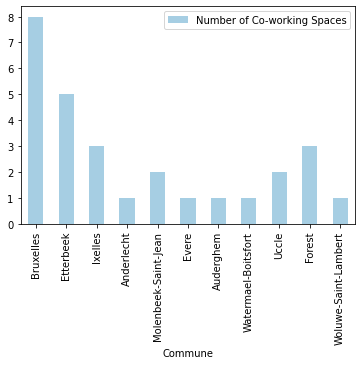

In [26]:
co_work_bar_plot = co_work_space[['Commune', 'Number of Co-working Spaces']]
co_work_space.plot.bar(x ='Commune',y= 'Number of Co-working Spaces',rot=0, colormap='Paired')
plt.xticks(rotation=90)

#### Thus only 11 communes of the total 19 hosts a co-working space. Largest number is seen in Bruxelles with post code 1000 and the second highest number seen in Etterbeek.The ideal location will also depend upon the number of venues of interest that are present.

## 3.1.2 Exploring the number of venues in each commune

In [27]:
print(brussels_venues.shape)
brussels_venues.tail()

(729, 7)


,Commune,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
724,Haren,50.890099,4.416321,Haren-Sud Gare / Haren-Zuid Station (MIVB / ST...,50.889810,4.414930,Bus Stop
725,Haren,50.890099,4.416321,Snack Verdun,50.891731,4.417738,Snack Place
726,Haren,50.890099,4.416321,Kortenbach (MIVB),50.892075,4.417218,Bus Stop
727,Haren,50.890099,4.416321,Kortenbachplein / Place Cortenbach,50.892389,4.417450,Plaza
728,Haren,50.890099,4.416321,Dienstpad Schaarbeek Group R - Haren-Zuid,50.890915,4.410647,Trail


In [72]:
brussels_venues.groupby('Commune').count() 
#plt.bar(k['Venue Category'],commune)

#plt.bar(k['Commune'],k['Venue Category'])
#ax = k.plot.bar(x='Commune', y='Venue Category', rot=0)


,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Commune,,,,,,
Anderlecht,35,35,35,35,35,35
Auderghem,42,42,42,42,42,42
Berchem-Sainte-Agathe,16,16,16,16,16,16
Bruxelles,100,100,100,100,100,100
Etterbeek,81,81,81,81,81,81
Evere,17,17,17,17,17,17
Forest,17,17,17,17,17,17
Ganshoren,20,20,20,20,20,20
Haren,9,9,9,9,9,9


In [29]:
print('There are {} uniques categories.'.format(len(brussels_venues['Venue Category'].unique())))

There are 185 uniques categories.


## 3.3 Analysing the number of venues of interest in each commune

### 3.3.1 One-hot encoding

One-hot encoding is used to represent the categorical data in a binary form. Thus the value is returned 1 only for the integer index else a 0 is returned.

In [30]:
# one hot encoding
brussels_onehot = pd.get_dummies(brussels_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brussels_onehot['Commune'] = brussels_venues['Commune'] 

# move neighborhood column to the first column
fixed_columns = [brussels_onehot.columns[-1]] + list(brussels_onehot.columns[:-1])
brussels_onehot = brussels_onehot[fixed_columns]

brussels_onehot.head()

,Commune,African Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bagel Shop,Bakery,Bar,Bath House,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brasserie,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Doner Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Court,Food Service,Football Stadium,French Restaurant,Fried Chicken Joint,Friterie,Furniture / Home Store,Garden,Gastropub,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Field,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Imported Food Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Lounge,Market,Martial Arts School,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Men's Store,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Nightclub,Noodle House,Notary,Optical Shop,Organic Grocery,Park,Pastry Shop,Pet Store,Pharmacy,Piano Bar,Pizza Place,Platform,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Record Shop,Recreation Center,Resort,Restaurant,Rooftop Bar,Salad Place,Sandwich Place,Seafood Restaurant,Shoe Store,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soup Place,Spanish Restaurant,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tailor Shop,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Video Game Store,Vietnamese Restaurant,Volleyball Court,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Anderlecht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Anderlecht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Anderlecht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Anderlecht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [31]:
brussels_onehot.shape

(729, 186)

In [32]:
brussels_grouped = brussels_onehot.groupby('Commune').max().reset_index()
brussels_grouped.head()

,Commune,African Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bagel Shop,Bakery,Bar,Bath House,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brasserie,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Doner Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Court,Food Service,Football Stadium,French Restaurant,Fried Chicken Joint,Friterie,Furniture / Home Store,Garden,Gastropub,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Field,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Imported Food Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Lounge,Market,Martial Arts School,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Men's Store,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Nightclub,Noodle House,Notary,Optical Shop,Organic Grocery,Park,Pastry Shop,Pet Store,Pharmacy,Piano Bar,Pizza Place,Platform,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Record Shop,Recreation Center,Resort,Restaurant,Rooftop Bar,Salad Place,Sandwich Place,Seafood Restaurant,Shoe Store,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soup Place,Spanish Restaurant,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tailor Shop,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Video Game Store,Vietnamese Restaurant,Volleyball Court,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Anderlecht,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0
1,Auderghem,0,0,0,0,0,1,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,Berchem-Sainte-Agathe,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,Bruxelles,0,0,1,1,1,0,0,1,1,0,0,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0,0,0,0,1,1,0,1,0,1,1,1,1,0,1,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,1,0,1,0,1,0,0,0,0,0,0,

In [33]:
brussels_grouped_narrowed = brussels_grouped[['Commune','Farmers Market','French Restaurant','Supermarket']]
brussels_grouped_narrowed

,Commune,Farmers Market,French Restaurant,Supermarket
0,Anderlecht,0,0,1
1,Auderghem,0,1,0
2,Berchem-Sainte-Agathe,0,1,1
3,Bruxelles,0,1,1
4,Etterbeek,1,1,1
5,Evere,0,0,1
6,Forest,0,1,1
7,Ganshoren,0,0,1
8,Haren,0,0,0
9,Ixelles,0,1,0


In [124]:
brussels_grouped_narrowed['sum'] = brussels_grouped['Farmers Market'] + brussels_grouped['French Restaurant'] + brussels_grouped['Supermarket']

<ipython-input-124-f02abe6d201b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brussels_grouped_narrowed['sum'] = brussels_grouped['Farmers Market'] + brussels_grouped['French Restaurant'] + brussels_grouped['Supermarket']


In [50]:
brussels_grouped_narrowed

,Commune,Farmers Market,French Restaurant,Supermarket,sum
0,Anderlecht,0,0,1,1
1,Auderghem,0,1,0,1
2,Berchem-Sainte-Agathe,0,1,1,2
3,Bruxelles,0,1,1,2
4,Etterbeek,1,1,1,3
5,Evere,0,0,1,1
6,Forest,0,1,1,2
7,Ganshoren,0,0,1,1
8,Haren,0,0,0,0
9,Ixelles,0,1,0,1


## 3.4 Clustering

### 3.4.1 Optimal value for clustering -Elbow Method

In [34]:
brussels_narrowed_clustering = brussels_grouped_narrowed.drop('Commune', 1)
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(brussels_narrowed_clustering)
    Sum_of_squared_distances.append(km.inertia_)

<ipython-input-34-cdc3e85ab863>:6: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  km = km.fit(brussels_narrowed_clustering)
<ipython-input-34-cdc3e85ab863>:6: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  km = km.fit(brussels_narrowed_clustering)
<ipython-input-34-cdc3e85ab863>:6: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  km = km.fit(brussels_narrowed_clustering)


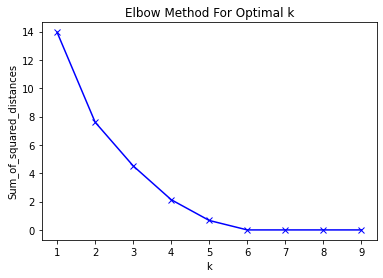

In [35]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### 3.4.2 Optimal value for clustering -Using Silhouette Method (For verfication)

The silhouette score is a measure of how similarity bewteen an object to its own cluster in comparison to other clusters. The value of score ranges between 1 and -1. The value of 1 indicates that the object is well matched to its cluster.

In [36]:
from sklearn.metrics import silhouette_score
range_n_clusters = list (range(2,10))
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(brussels_narrowed_clustering)
    centers = clusterer.cluster_centers_

    score = silhouette_score(brussels_narrowed_clustering, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.47996242089408375)
For n_clusters = 3, silhouette score is 0.5991494907494747)
For n_clusters = 4, silhouette score is 0.7734721988685807)
For n_clusters = 5, silhouette score is 0.9090909090909091)
For n_clusters = 6, silhouette score is 0.9545454545454546)
For n_clusters = 7, silhouette score is 0.9545454545454546)


/Users/nimmysamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/nimmysamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 8, silhouette score is 0.9545454545454546)
For n_clusters = 9, silhouette score is 0.9545454545454546)


/Users/nimmysamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


#### We thus choose k value of 5 to cluster the dataset into 5

### 3.4.3 Clustering based on the k value

In [37]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brussels_narrowed_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:24]

array([1, 0, 2, 2, 4, 1, 2, 1, 3, 0, 1, 2, 3, 1, 3, 4, 2, 4, 4, 0, 2, 3],
      dtype=int32)

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [40]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Commune']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
districts_venues_sorted = pd.DataFrame(columns=columns)
districts_venues_sorted['Commune'] = brussels_grouped['Commune']

for ind in np.arange(brussels_grouped_narrowed.shape[0]):
    districts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brussels_grouped.iloc[ind, :], num_top_venues)

districts_venues_sorted

,Commune,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anderlecht,Ice Cream Shop,Belgian Restaurant,Creperie,Plaza,Coffee Shop,Cocktail Bar,Pub,Restaurant,Salad Place,Sandwich Place
1,Auderghem,Ice Cream Shop,Sushi Restaurant,Shoe Store,Carpet Store,Salad Place,Resort,Cocktail Bar,Portuguese Restaurant,Plaza,Pizza Place
2,Berchem-Sainte-Agathe,Convenience Store,Gym,Plaza,Restaurant,Sandwich Place,Snack Place,Burger Joint,French Restaurant,Greek Restaurant,Tram Station
3,Bruxelles,Yoga Studio,Imported Food Shop,Dessert Shop,Ethiopian Restaurant,Fish & Chips Shop,French Restaurant,Greek Restaurant,Herbs & Spices Store,Hotel,Hotel Bar
4,Etterbeek,Ice Cream Shop,Seafood Restaurant,Massage Studio,Event Service,Modern European Restaurant,Doner Restaurant,Diner,Deli / Bodega,Concert Hall,Comedy Club
5,Evere,Hockey Field,Bookstore,Pizza Place,Restaurant,Snack Place,Sports Bar,Martial Arts School,Supermarket,Football Stadium,Brasserie
6,Forest,Plaza,Tram Station,Park,Factory,Snack Place,Men's Store,French Restaurant,Friterie,Bistro,Train Station
7,Ganshoren,Deli / Bodega,Tram Station,Bus Station,Medical Supply Store,Park,Supermarket,Friterie,Boutique,Thai Restaurant,Belgian Restaurant
8,Haren,Train Station,Platform,Plaza,Bus Stop,Snack Place,Comedy Club,Trail,Electronics Store,Farmers Market,Falafel Restaurant
9,Ixelles,African Restaurant,Mediterranean Restaurant,Tea Room,Fried Chicken Joint,Sushi Restaurant,French Restaurant,Breakfast Spot,Pool Hall,Korean Restaurant,Portuguese Restaurant


In [41]:
# add clustering labels
districts_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#brussels_merged = brussel_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
brussels_merged = brussel_data.join(districts_venues_sorted.set_index('Commune'), on='Commune')

# check the last columns!

In [42]:
brussels_merged.head()

,PostCode,Commune,Country,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1070,Anderlecht,Belgium,50.839098,4.329653,1,Ice Cream Shop,Belgian Restaurant,Creperie,Plaza,Coffee Shop,Cocktail Bar,Pub,Restaurant,Salad Place,Sandwich Place
1,1160,Auderghem,Belgium,50.817235,4.426898,0,Ice Cream Shop,Sushi Restaurant,Shoe Store,Carpet Store,Salad Place,Resort,Cocktail Bar,Portuguese Restaurant,Plaza,Pizza Place
2,1082,Berchem-Sainte-Agathe,Belgium,50.864923,4.294673,2,Convenience Store,Gym,Plaza,Restaurant,Sandwich Place,Snack Place,Burger Joint,French Restaurant,Greek Restaurant,Tram Station
3,1040,Etterbeek,Belgium,50.836145,4.386174,4,Ice Cream Shop,Seafood Restaurant,Massage Studio,Event Service,Modern European Restaurant,Doner Restaurant,Diner,Deli / Bodega,Concert Hall,Comedy Club
4,1140,Evere,Belgium,50.872010,4.403418,1,Hockey Field,Bookstore,Pizza Place,Restaurant,Snack Place,Sports Bar,Martial Arts School,Supermarket,Football Stadium,Brasserie


In [43]:
brussels_merged.loc[brussels_merged['Cluster Labels'] == 0, brussels_merged.columns[[1] + list(range(5, brussels_merged.shape[1]))]]

,Commune,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Auderghem,0,Ice Cream Shop,Sushi Restaurant,Shoe Store,Carpet Store,Salad Place,Resort,Cocktail Bar,Portuguese Restaurant,Plaza,Pizza Place
7,Ixelles,0,African Restaurant,Mediterranean Restaurant,Tea Room,Fried Chicken Joint,Sushi Restaurant,French Restaurant,Breakfast Spot,Pool Hall,Korean Restaurant,Portuguese Restaurant
15,Watermael-Boitsfort,0,Ice Cream Shop,Convenience Store,Bus Stop,Skate Park,Café,Sandwich Place,Chinese Restaurant,Restaurant,Park,Thai Restaurant


In [45]:
brussels_merged.loc[brussels_merged['Cluster Labels'] == 1, brussels_merged.columns[[1] + list(range(5, brussels_merged.shape[1]))]]

,Commune,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anderlecht,1,Ice Cream Shop,Belgian Restaurant,Creperie,Plaza,Coffee Shop,Cocktail Bar,Pub,Restaurant,Salad Place,Sandwich Place
4,Evere,1,Hockey Field,Bookstore,Pizza Place,Restaurant,Snack Place,Sports Bar,Martial Arts School,Supermarket,Football Stadium,Brasserie
6,Ganshoren,1,Deli / Bodega,Tram Station,Bus Station,Medical Supply Store,Park,Supermarket,Friterie,Boutique,Thai Restaurant,Belgian Restaurant
8,Jette,1,Pizza Place,Brasserie,Supermarket,Snack Place,Market,Sandwich Place,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop
10,Molenbeek-Saint-Jean,1,Supermarket,Coffee Shop,Dance Studio,Snack Place,Burger Joint,Tram Station,Nightclub,Buffet,History Museum,Hostel


In [46]:
brussels_merged.loc[brussels_merged['Cluster Labels'] == 2, brussels_merged.columns[[1] + list(range(5, brussels_merged.shape[1]))]]

,Commune,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Berchem-Sainte-Agathe,2,Convenience Store,Gym,Plaza,Restaurant,Sandwich Place,Snack Place,Burger Joint,French Restaurant,Greek Restaurant,Tram Station
5,Forest,2,Plaza,Tram Station,Park,Factory,Snack Place,Men's Store,French Restaurant,Friterie,Bistro,Train Station
9,Koekelberg,2,Convenience Store,Train Station,Snack Place,Soccer Field,Sandwich Place,Park,Supermarket,French Restaurant,Moving Target,Falafel Restaurant
12,Saint-Josse-ten-Noode,2,Ice Cream Shop,Snack Place,Sandwich Place,Restaurant,Plaza,Pizza Place,Pastry Shop,Music Venue,Moroccan Restaurant,Monument / Landmark
16,Woluwe-Saint-Lambert,2,Ice Cream Shop,Toy / Game Store,Park,Department Store,Dog Run,Electronics Store,Restaurant,Clothing Store,Event Space,Men's Store
18,Bruxelles,2,Yoga Studio,Imported Food Shop,Dessert Shop,Ethiopian Restaurant,Fish & Chips Shop,French Restaurant,Greek Restaurant,Herbs & Spices Store,Hotel,Hotel Bar


In [47]:
brussels_merged.loc[brussels_merged['Cluster Labels'] == 3, brussels_merged.columns[[1] + list(range(5, brussels_merged.shape[1]))]]

,Commune,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Woluwe-Saint-Pierre,3,Moving Target,Recreation Center,Tennis Court,Brasserie,Belgian Restaurant,Museum,Tram Station,Lounge,Athletics & Sports,Sports Club
19,Laeken,3,Dance Studio,Italian Restaurant,Monument / Landmark,Bus Stop,Friterie,Electronics Store,Park,Tram Station,Dog Run,Factory
20,Neder-Over-Heembeek,3,Bakery,Convenience Store,Chinese Restaurant,Greek Restaurant,Flower Shop,Friterie,Bookstore,Park,Bus Stop,Pharmacy
21,Haren,3,Train Station,Platform,Plaza,Bus Stop,Snack Place,Comedy Club,Trail,Electronics Store,Farmers Market,Falafel Restaurant


In [48]:
brussels_merged.loc[brussels_merged['Cluster Labels'] == 4, brussels_merged.columns[[1] + list(range(5, brussels_merged.shape[1]))]]

,Commune,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Etterbeek,4,Ice Cream Shop,Seafood Restaurant,Massage Studio,Event Service,Modern European Restaurant,Doner Restaurant,Diner,Deli / Bodega,Concert Hall,Comedy Club
11,Saint-Gilles,4,Pizza Place,Friterie,Brasserie,Supermarket,French Restaurant,Brewery,Latin American Restaurant,Sandwich Place,Café,Farmers Market
13,Schaerbeek,4,Plaza,Convenience Store,Middle Eastern Restaurant,Snack Place,Bus Line,Spanish Restaurant,Coffee Shop,Supermarket,French Restaurant,Brasserie
14,Uccle,4,Food Service,Breakfast Spot,Thai Restaurant,Chinese Restaurant,Juice Bar,Swiss Restaurant,Plaza,Supermarket,French Restaurant,Theme Restaurant


### 3.5 Map of Brussels based on clustered communes

In [49]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brussels_merged['Latitude'], brussels_merged['Longitude'], brussels_merged['Commune'], brussels_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 3.5.1 Explaing the clusters based on colours 
* 0 - Only French Restaurant or Farmers market is present or both (Violet)

* 1 - Two venues are present including supermarket (Light Blue)

* 2 - Only supermarket is present (Light Green)

* 3 - None of the venues are present (Orange)

* 4 - All three venues are present (red

Thus we see that Etterbeek, Uccle, Schaerbeek and Saint Gilles are ideal locations for pierre in terms of venues present.
Do these venues also have co-working spaces?

## 3.6 Results and Discussion

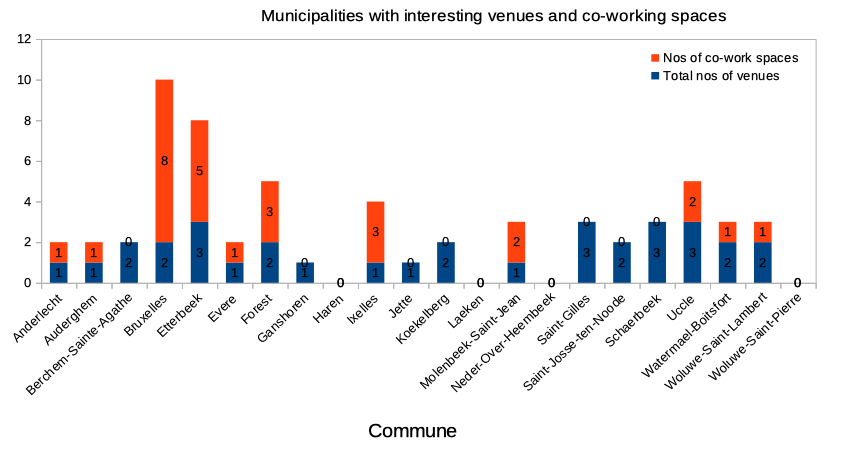

In [50]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "/Users/nimmysamson/Desktop/"
Image(filename = PATH + "final.png", width=1000, height=1000)

The figure shows that there are indeed some locations which will be most suitable for Pierre. Since Saint-Gilles and Schaerbeek do not have co-working spaces, these can be effectively removed from the most desired locations. There are also 7 municipalities where any of the two specified venues are present. These venues could be used as secondary options for Pierre provided co-working spaces are available. Out of the 7 municipalities 4 of them are suitable as the next best options.

Though the Etterbeek and Uccle have all three venues and also have available work spaces, there are also several deciding factors that determines if the place is most suitable or not. Some of these factors could be availability of apartments in the regions, rental prices of apartments and studio flats in those areas, noise in the region and so on.

## 4.Conclusion

The main aim of this project was to identify the ideal place in Brussels to relocate and start a new startup business for Pierre. With relocation comes the challenge of acclimatising the city which could bedifficult since there are always certain areas near your home that a person will wish he had in the newplace. Hence to make this relocation go smoothly as possible Pierre suggested certain venues he wishes to have near his ideal location in addition to the presence of a co-working space. This will help Pierreto choose a studio in the location selected.

From the list of venues grouped by the name of municipality we could extract three venues whichare required to be present in the ideal location according to Pierre. A total of five municipalities havethe desired venues as suggested by Pierre. The locations are then clustered into five based on the k-means clustered algorithm. The list of ideal location is narrowed down by comparing with the numberof co-working spaces available. This then results in two ideal locations. 

Etterbeek and Uccle have 5 and 1 co-working spaces respectively. We then try to suggest a better option of the two based on demography and rental prices per apartmentin each commune. Considering all the above factors , Etterbeek is considered to be the ideal choicefor Pierre for his relocation and start up company.
